In [68]:
using FEM, Potential, Diffusity, PyPlot, Printf, JLD, Dierckx, AlphaBeta, LinearAlgebra

### Part 1: Get collocation points and integration kernel for whole domain

In [12]:
Nh = 64    # The number of Spectral element
Np = 4     # The order of polynomial which used to interpolate and integration
Nv = 72

# Define Physical Domain
xratio = 64. # unit: angstrom
xavg = 0.    # unit: angstrom

x, w, Ldx, L = getLagrange(Np, xratio/Nh)
e_norm = x[end] - x[1]
interpo_xs = x .+ x[end]

N, xref, w0, Ldx, w = get_fem_xref_weights_basis(Nh, Np, xratio, xavg);

### Part 2: Set $V(x)$

In [3]:
sigma_kref = 10.
kref = get_k_by_sigma(sigma_kref)
Vref = harmonic_well_k_mean(xref, kref, xavg)
rho_eq = get_rhoeq(Vref, w0)
p_eq = rho_eq .* rho_eq
F_xref = force_harmonic_well_k_mean.(xref, kref, xavg);

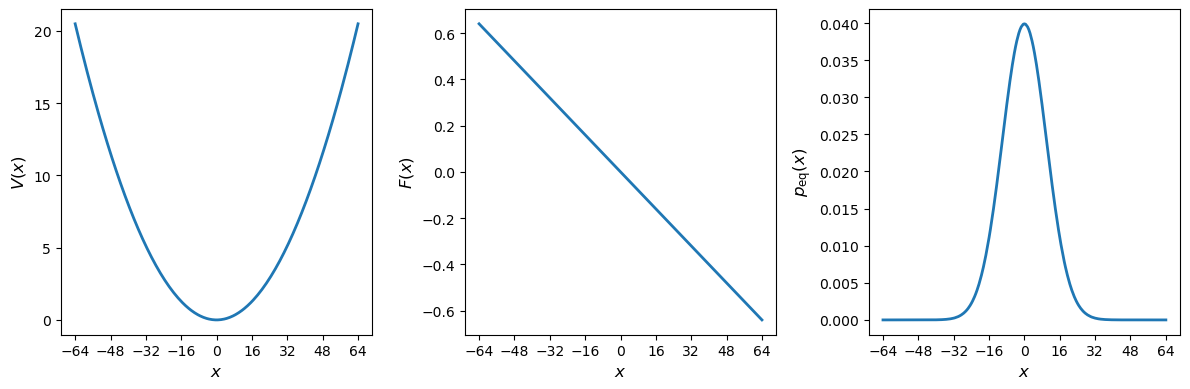

In [4]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12,4))

ax = axes[1]
ax.plot(xref, Vref, linewidth=2)
ax.set_xlabel("\$x\$", fontsize=12)
ax.set_ylabel("\$V(x)\$", fontsize=12)
ax.set_xticks(-64:16:64)

ax = axes[2]
ax.plot(xref, F_xref, linewidth=2)
ax.set_xlabel("\$x\$", fontsize=12)
ax.set_ylabel("\$F(x)\$", fontsize=12)
ax.set_xticks(-64:16:64)

ax = axes[3]
ax.plot(xref, p_eq, linewidth=2)
ax.set_xlabel("\$x\$", fontsize=12)
ax.set_ylabel("\$p_{\\rm eq}(x)\$", fontsize=12)
ax.set_xticks(-64:16:64)

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/harmonic_potential_force_0.pdf")
plt.show()

### Part 3: Distance-dependent diffusion coefficient $D(x)$

In [19]:
xleft = -64
xright = 64
yleft = 250
yright = 750
c = 500
D_constant = c
D_array = Diffusity.linear.(xleft, xright, yleft, yright, xref, c)
D_spl = Spline1D(xref[:,1], D_array[:,1])
eta_array = D_array .- D_constant;

In [6]:
dDdx_xref = zeros(N)
for idx = 1:N
    dDdx_xref[idx] = derivative(D_spl, xref[idx])
end

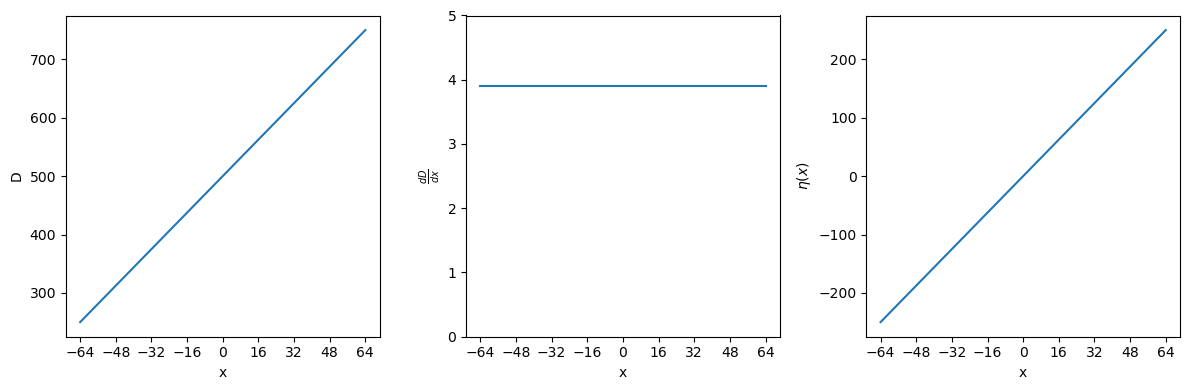

In [22]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12,4))

ax = axes[1]
ax.plot(xref, D_array)
ax.set_xlabel("x")
ax.set_ylabel("D")
ax.set_xticks(-64:16:64)

ax = axes[2]
ax.plot(xref, dDdx_xref)
ax.set_xlabel("x")
ax.set_ylabel("\$\\frac{dD}{dx}\$")
ax.set_xticks(-64:16:64)
ax.set_ylim(0,5)

ax = axes[3]
ax.plot(xref, eta_array)
ax.set_xlabel("x")
ax.set_ylabel("\$\\eta(x)\$")
ax.set_xticks(-64:16:64)

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/distance_dependent_D.pdf")
plt.show()

### Part 4: Eigenbasis of $\textbf{H}^0$

In [13]:
eigenvalues, eigenvec_mat, rho_eq = fem_solve_eigen_by_pref(Nh, Np, xratio, xavg, p_eq, D_constant, Nv);

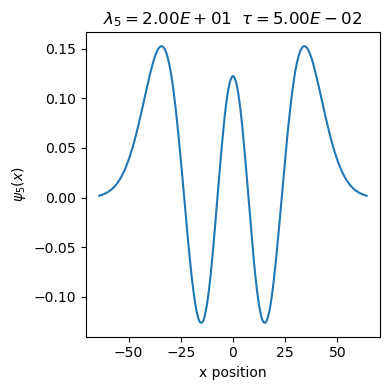

In [111]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4,4))

idx_eigvector = 5
plot_x_Qx_lambda(ax, idx_eigvector, eigenvalues, eigenvec_mat, xref)
plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/distance_dependent_D.pdf")
plt.show()

### Part 5: $\langle \psi_i^0 | \textbf{H}^D |\psi^0_j \rangle$

In [61]:
i_idx = 1
j_idx = 2;

$\int  \eta(x) \frac{\partial \psi_i^0(x)}{\partial x} \frac{\partial \psi^0_j(x)}{\partial x} dx$

In [62]:
eigv_i_spl = Spline1D(xref[:,1], eigenvec_mat[:, i_idx])
eigv_j_spl = Spline1D(xref[:,1], eigenvec_mat[:, j_idx])

eigv_i_derivative = zeros(N)
eigv_j_derivative = zeros(N)

for idx = 1:N
    eigv_i_derivative[idx] = derivative(eigv_i_spl, xref[idx])
    eigv_j_derivative[idx] = derivative(eigv_j_spl, xref[idx])
end

In [63]:
first_term = sum(eta_array .* eigv_i_derivative .* eigv_j_derivative)

0.14648385597539512

$\frac{1}{2} \int \eta(x)\frac{d F(x)}{dx} \psi_i^0(x) \psi^0_j(x) dx$

In [37]:
F_derivative = -kref
second_term = sum((F_derivative * eta_array) .* eigenvec_mat[:, i_idx] .* eigenvec_mat[:, j_idx]) / 2

-0.14648391855544857

$\frac{1}{4} \int \eta(x) F^{2}(x) \psi_i^0(x) \psi^0_j(x) dx$

In [44]:
third_term = sum(eta_array .* F_xref .* F_xref .* eigenvec_mat[:, i_idx] .* eigenvec_mat[:, j_idx]) / 4

0.4394517056031508

$\frac{1}{2} \int \frac{\partial \eta(x)}{\partial x} F(x) \psi_i^0(x) \psi^0_j(x) dx$

In [47]:
fourth_term = sum(dDdx_xref .* F_xref .* eigenvec_mat[:, i_idx] .* eigenvec_mat[:, j_idx]) / 2

-0.2929678371108953

### Part 6: Matrix $K$

In [65]:
function get_eigv_derivative(xref, idx_eigv, Qx, N)
    eigv_spl = Spline1D(xref[:,1], Qx[:, idx_eigv])
    eigv_derivative = zeros(N)
    for idx = 1:N
        eigv_derivative[idx] = derivative(eigv_spl, xref[idx])
    end
    return eigv_derivative
end

get_eigv_derivative (generic function with 1 method)

In [87]:
K_matrix = zeros(Nv, Nv)

for i_idx = 1:Nv
    eigv_i_derivative = get_eigv_derivative(xref, i_idx, eigenvec_mat, N)
    for j_idx = 1:Nv
        eigv_j_derivative = get_eigv_derivative(xref, j_idx, eigenvec_mat, N)
        
        F_derivative = -kref
        
        first_term = sum(eta_array .* eigv_i_derivative .* eigv_j_derivative)        
        second_term = sum((F_derivative * eta_array) .* eigenvec_mat[:, i_idx] .* eigenvec_mat[:, j_idx]) / 2
        third_term = sum(eta_array .* F_xref .* F_xref .* eigenvec_mat[:, i_idx] .* eigenvec_mat[:, j_idx]) / 4
        fourth_term = sum(dDdx_xref .* F_xref .* eigenvec_mat[:, i_idx] .* eigenvec_mat[:, j_idx]) / 2
        final_result = first_term + second_term + third_term + fourth_term
        
        if i_idx == j_idx
            K_matrix[i_idx, j_idx] = final_result + eigenvalues[i_idx]
        else
            K_matrix[i_idx, j_idx] = final_result
            K_matrix[j_idx, i_idx] = final_result
        end
    end
end

### Part 7: Eigen-decompose $K$

In [88]:
F = eigen(K_matrix)
K_eigenvalues = F.values
K_eigenvect_mat = F.vectors;

In [89]:
H_eigenvect_mat = eigenvec_mat * transpose(K_eigenvect_mat);

In [90]:
sum(w0 .* H_eigenvect_mat[:, 5] .* H_eigenvect_mat[:, 5])

1.0000000013024641

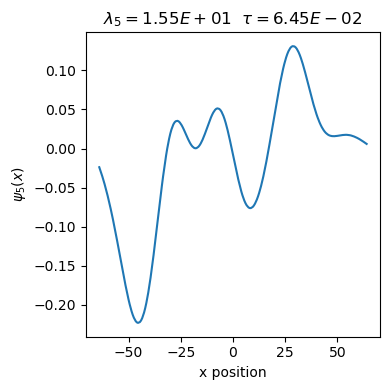

In [112]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4,4))

idx_eigvector = 5
plot_x_Qx_lambda(ax, idx_eigvector, K_eigenvalues, H_eigenvect_mat, xref)
plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/distance_dependent_D.pdf")
plt.show()